In [ ]:
import sys
sys.path.append("..")

In [1]:
# ============================================================
# Adapter: run M-GW on SpatialMETA Y7 ST & SM .h5ad files
# ============================================================
import anndata as ad
import numpy as np, torch, scipy.sparse as sp
from mgw import plotting, models, geometry
from mgw import pullback_metric_field, knn_graph
import importlib; importlib.reload(geometry)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(torch.float64)
print("Device:", device)

# ----------------------------
# Config
# ----------------------------

st_path = "/scratch/gpfs/ph3641/mgw/adata_ST_Y7_T_raw.h5ad"
sm_path = "/scratch/gpfs/ph3641/mgw/adata_SM_Y7_T_raw.h5ad"

# Which layer to use for features; set to None to use .X
ST_LAYER = None
SM_LAYER = None

# Preprocessing
log1p_features = True
zscore_per_feature = True
n_features_st = 256   # set None to keep all
n_features_sm = 256   # set None to keep all

# Graph / geodesic params
knn_k = 30
geodesic_eps = 1e-6   # used inside pullback metric calc

# ----------------------------
# Helpers
# ----------------------------
def _to_dense(X):
    if sp.issparse(X): return X.toarray()
    return np.asarray(X)

def normalize_coords_to_unit_square(Xxy):
    Xxy = np.asarray(Xxy, dtype=np.float64)
    m = Xxy.min(0, keepdims=True)
    M = Xxy.max(0, keepdims=True)
    return (Xxy - m) / (M - m + 1e-12)

def log1p_if(X):
    return np.log1p(X) if log1p_features else X

def zscore_features(X):
    if not zscore_per_feature: return X
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-12
    return (X - mu)/sd

def top_var_idx(X, n_keep):
    if (n_keep is None) or (n_keep >= X.shape[1]): 
        return np.arange(X.shape[1])
    # unbiased sample variance per feature
    v = X.var(axis=0, ddof=1)
    return np.argsort(v)[-n_keep:]

def ann_load(path, layer=None):
    adata = ad.read_h5ad(path)
    if "spatial" not in adata.obsm:
        raise ValueError(f"{path} missing .obsm['spatial']")
    X = _to_dense(adata.layers[layer]) if (layer is not None and layer in adata.layers) else _to_dense(adata.X)
    XY = np.asarray(adata.obsm["spatial"], dtype=np.float64)
    return XY, X, adata



Device: cuda


In [2]:
import scanpy as sc
import numpy as np
import scipy.sparse as sp

A = sc.read_h5ad("/scratch/gpfs/ph3641/mgw/adata_joint_S15_T_raw.h5ad")

# --- Build boolean masks on vars ---
type_col = None
for cand in ["type", "modality", "feature_type"]:
    if cand in A.var.columns:
        type_col = cand
        break

if type_col is not None:
    t = A.var[type_col].astype(str).str.lower().fillna("")
    is_gene = t.str.contains("gene|rna|st")
    is_met  = t.str.contains("met|sm|metab")
else:
    v = A.var_names.astype(str)
    is_met  = v.str.contains(r"^\d+(\.\d+)?$|^mz[_\-]|^m/z", case=False, regex=True)
    is_gene = ~is_met

# Convert to numpy bool arrays 
is_gene = np.asarray(is_gene, dtype=bool)
is_met  = np.asarray(is_met,  dtype=bool)

# Safety checks
assert is_gene.shape[0] == A.n_vars and is_met.shape[0] == A.n_vars
assert (is_gene & is_met).sum() == 0, "Masks overlap; refine rules."
assert is_gene.sum() > 0 and is_met.sum() > 0, "One mask is empty."

# --- Subset the AnnData the AnnData way (keeps obsm/obs/var nicely) ---
adata_st = A[:, is_gene].copy()
adata_sm = A[:, is_met].copy()

# Coordinates
st_xy = adata_st.obsm["spatial"]
sm_xy = adata_sm.obsm["spatial"]

# Dense feature matrices 
st_X = adata_st.X.toarray() if sp.issparse(adata_st.X) else np.asarray(adata_st.X)
sm_X = adata_sm.X.toarray() if sp.issparse(adata_sm.X) else np.asarray(adata_sm.X)

print("ST spots × feats:", st_X.shape, "SM spots × feats:", sm_X.shape)

# ----------------------------
# Basic preprocessing 
# ----------------------------
st_xy_n = normalize_coords_to_unit_square(st_xy)
sm_xy_n = normalize_coords_to_unit_square(sm_xy)

ST spots × feats: (2841, 36601) SM spots × feats: (2841, 1299)


In [3]:


def pca_from(adata, *, layer=None, n_comps=30, log1p=True, scale_if_dense=True):
    """Return n_comps PCA coords from an AnnData (handles sparse vs dense)."""
    ad_tmp = adata.copy()
    if layer is not None and layer in ad_tmp.layers:
        ad_tmp.X = ad_tmp.layers[layer]

    # optional log1p
    if log1p:
        sc.pp.log1p(ad_tmp)
        
    is_sparse = sp.issparse(ad_tmp.X)
    zero_center = not is_sparse

    # scale to unit variance if dense (common before PCA)
    if scale_if_dense and zero_center:
        sc.pp.scale(ad_tmp, max_value=10)  # clip heavy tails a bit

    # run PCA
    sc.tl.pca(
        ad_tmp,
        n_comps=n_comps,
        zero_center=zero_center,           # False for sparse -> TruncatedSVD-style
        svd_solver="arpack" if zero_center else "auto"
    )
    return np.asarray(ad_tmp.obsm["X_pca"], dtype=np.float64)


In [4]:

PCA_comp = 20
CCA_comp = 2

# build features from PCA for each modality
st_pca = pca_from(adata_st, layer=ST_LAYER, n_comps=PCA_comp, log1p=log1p_features)
sm_pca = pca_from(adata_sm, layer=SM_LAYER, n_comps=PCA_comp, log1p=log1p_features)

print("PCA shapes -> ST:", st_pca.shape, "SM:", sm_pca.shape)


/tmp/ipykernel_1068143/2269070356.py:20: UserWarning: Ignoring svd_solver='auto' and using randomized, sklearn.decomposition._truncated_svd.TruncatedSVD only supports dict_keys(['arpack', 'randomized']).
  sc.tl.pca(


PCA shapes -> ST: (2841, 20) SM: (2841, 20)


In [5]:

from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

st_scaled = StandardScaler().fit_transform(st_pca)
sm_scaled = StandardScaler().fit_transform(sm_pca)

cca = CCA(n_components=CCA_comp)
st_cca, sm_cca = cca.fit_transform(st_scaled, sm_scaled)


In [6]:

ys_t  = torch.from_numpy(st_cca).to(device)   # (n, 30)
ys2_t = torch.from_numpy(sm_cca).to(device)   # (m, 30)

xs_t  = torch.from_numpy(st_xy_n).to(device)            # (n,2)
xs2_t = torch.from_numpy(sm_xy_n).to(device)            # (m,2)

dim_e   = 2
dim_f_M = ys_t.shape[1]   # 30
dim_f_N = ys2_t.shape[1]  # 30

print("dims:", dim_e, dim_f_M, dim_f_N)


dims: 2 2 2


In [7]:

# ----------------------------
# Learn φ, ψ : (coords)->(features)
# ----------------------------
phi = models.PhiModel(dim_e, dim_f_M, widths=(128,256,256,128)).to(device)
psi = models.PhiModel(dim_e, dim_f_N, widths=(128,256,256,128)).to(device)

phi = models.train_phi(phi, xs_t, ys_t, lr=1e-3, niter=10000, print_every=500, device=device)
psi = models.train_phi(psi, xs2_t, ys2_t, lr=1e-3, niter=10000, print_every=500, device=device)
phi.eval(); psi.eval()


[train_phi] step=500 loss=0.436782
[train_phi] step=1000 loss=0.361804
[train_phi] step=1500 loss=0.373525
[train_phi] step=2000 loss=0.327748
[train_phi] step=2500 loss=0.316944
[train_phi] step=3000 loss=0.308956
[train_phi] step=3500 loss=0.348351
[train_phi] step=4000 loss=0.288880
[train_phi] step=4500 loss=0.333317
[train_phi] step=5000 loss=0.276287
[train_phi] step=5500 loss=0.267970
[train_phi] step=6000 loss=0.265190
[train_phi] step=6500 loss=0.260720
[train_phi] step=7000 loss=0.267281
[train_phi] step=7500 loss=0.256249
[train_phi] step=8000 loss=0.252142
[train_phi] step=8500 loss=0.271004
[train_phi] step=9000 loss=0.294630
[train_phi] step=9500 loss=0.242656
[train_phi] step=10000 loss=0.238742
[train_phi] step=500 loss=0.236612
[train_phi] step=1000 loss=0.147259
[train_phi] step=1500 loss=0.132438
[train_phi] step=2000 loss=0.131602
[train_phi] step=2500 loss=0.114960
[train_phi] step=3000 loss=0.108748
[train_phi] step=3500 loss=0.104204
[train_phi] step=4000 loss=0.

PhiModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Softplus(beta=1.0, threshold=20.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): Softplus(beta=1.0, threshold=20.0)
    (8): Linear(in_features=128, out_features=2, bias=True)
  )
)

# Pretty underfitted, but easy to improve..

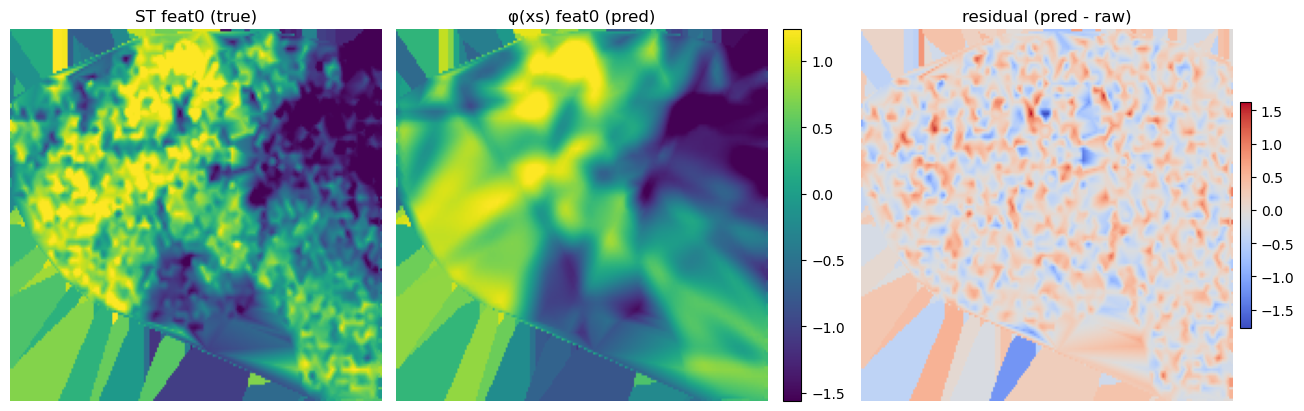

φ feat 0 {'mse': np.float64(0.16584150883421764), 'r2': np.float64(0.809517189311628), 'corr': np.float64(0.8998167374520886)}


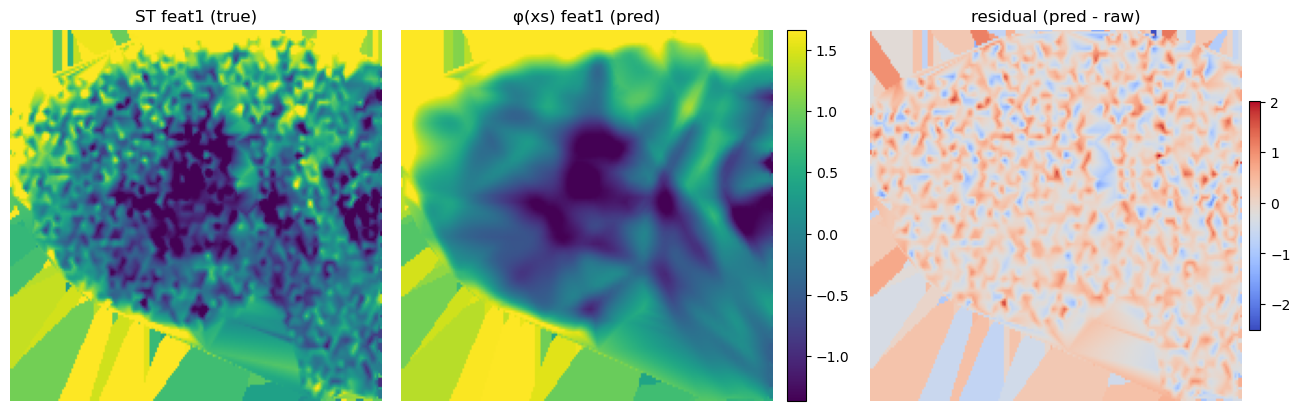

φ feat 1 {'mse': np.float64(0.3116111246278159), 'r2': np.float64(0.6889920637215683), 'corr': np.float64(0.8301792923376602)}


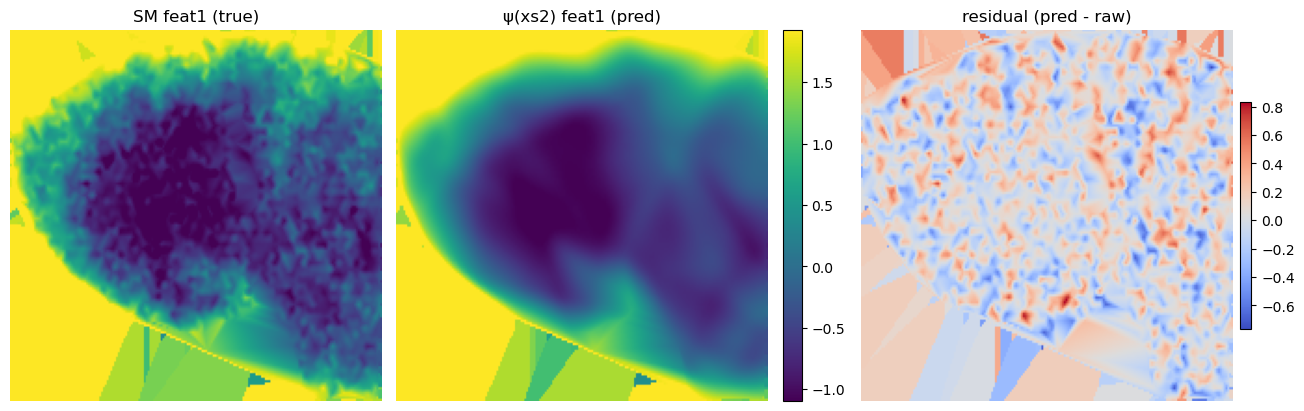

ψ feat 1 {'mse': np.float64(0.06073461742762227), 'r2': np.float64(0.9331346662194213), 'corr': np.float64(0.9660535642200213)}


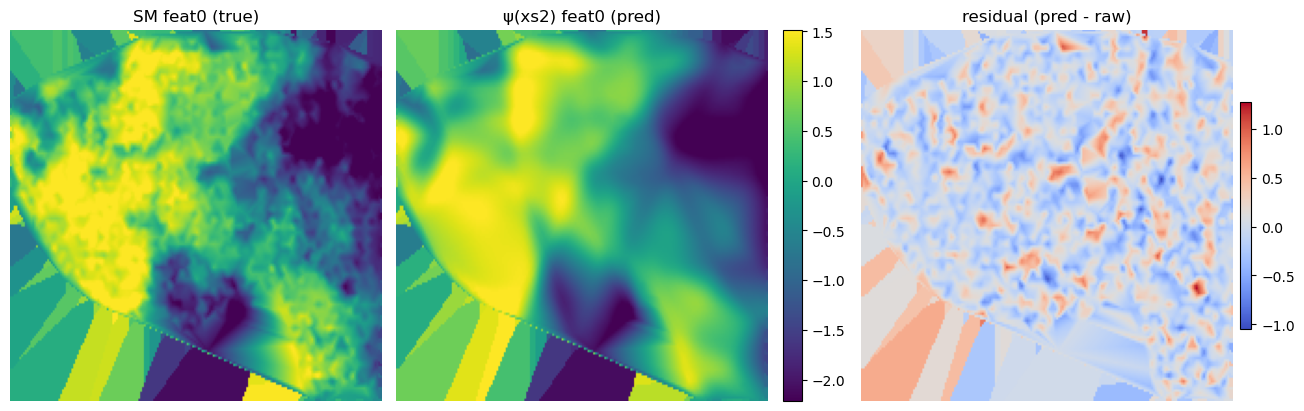

ψ feat 0 {'mse': np.float64(0.08872578266102202), 'r2': np.float64(0.940901744694099), 'corr': np.float64(0.970110569791481)}


In [8]:

# quick sanity plots/metrics on a couple random channels
import numpy as np
from mgw.plotting import fit_metrics
rng = np.random.default_rng(0)
for k in rng.choice(dim_f_M, size=min(2, dim_f_M), replace=False):
    X_pred = plotting.predict_on_model(phi, st_xy_n)
    plotting.plot_fit_on_cloud(st_xy_n, ys_t[:,k].cpu().numpy(), X_pred[:,k],
                               title_true=f'ST feat{k} (true)', title_pred=f'φ(xs) feat{k} (pred)')
    print('φ feat', k, fit_metrics(ys_t[:,k].cpu().numpy(), X_pred[:,k]))
    
for k in rng.choice(dim_f_N, size=min(2, dim_f_N), replace=False):
    Z_pred = plotting.predict_on_model(psi, sm_xy_n)
    plotting.plot_fit_on_cloud(sm_xy_n,ys2_t[:,k].cpu().numpy(), Z_pred[:,k],
                               title_true=f'SM feat{k} (true)', title_pred=f'ψ(xs2) feat{k} (pred)')
    print('ψ feat', k, fit_metrics(ys2_t[:,k].cpu().numpy(), Z_pred[:,k]))



In [9]:
from mgw.gw import solve_gw_ott

# ---------------------------------------
# Pull-back metric tensor fields g^M, g^N
# ---------------------------------------
G_M = pullback_metric_field(phi, torch.from_numpy(st_xy_n).to(device), eps=geodesic_eps).cpu()   # (n,2,2)
G_N = pullback_metric_field(psi, torch.from_numpy(sm_xy_n).to(device), eps=geodesic_eps).cpu()   # (m,2,2)
print('Computed pull-back Jacobian fields')

# ----------------------------
# kNN graphs + geodesics
# ----------------------------
G_s = knn_graph(st_xy_n,  k=knn_k)
G_t = knn_graph(sm_xy_n,  k=knn_k)
print('Built kNN graphs')

D_M = geometry.geodesic_distances_fast(st_xy_n,  G_M, G_s)  # (n,n)
D_N = geometry.geodesic_distances_fast(sm_xy_n,  G_N, G_t)  # (m,m)
print('Geodesics computed')

def normalize_geodesics(D):
    D = np.maximum(D, 0.0)
    np.fill_diagonal(D, 0.0)
    q = np.quantile(D[np.triu_indices_from(D, k=1)], 0.99)
    return D / (q + 1e-12)

D_Mn = normalize_geodesics(D_M)
D_Nn = normalize_geodesics(D_N)
C_M  = D_Mn**2
C_N  = D_Nn**2

# ----------------------------
# Solve GW on squared geodesic costs
# ----------------------------

gw_params = dict(verbose=True, inner_maxit=2000, outer_maxit=2000,
                 inner_tol=1e-8, outer_tol=1e-8, epsilon=1e-3)

P = solve_gw_ott(C_M, C_N, **gw_params)
print("Coupling:", P.shape, "sum:", P.sum())


Computed pull-back Jacobian fields
Built kNN graphs
Geodesics computed
[OTT] GW  ε=1.00e-03  iters=-1  loss≈1.1657e-02
Coupling: (2841, 2841) sum: 0.9999999


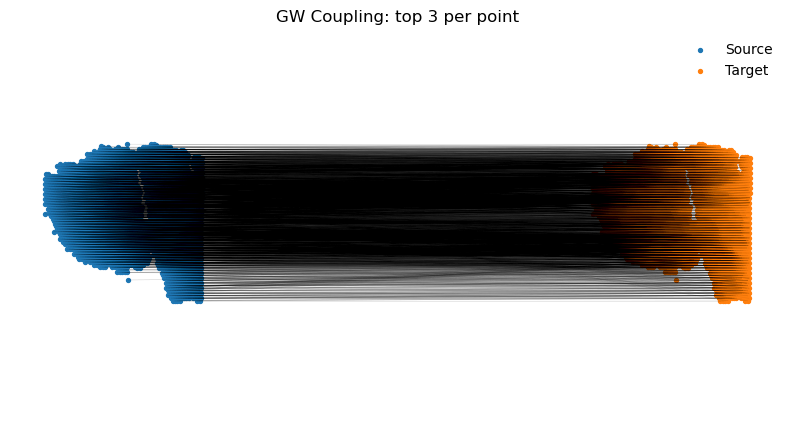

In [10]:

plotting.plot_alignment_lines_dense(st_xy_n, sm_xy_n, P, alpha=0.05)
